In [1]:
#plots.py
import os
import pandas
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import datetime
import math

def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

def plot_ts_scatter(df, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    plot_vars = list(df.keys())
    for var1 in plot_vars:
        for var2 in plot_vars:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(plot_vars).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_lines(df, title = False, linewidth = 1, figsize = (40,20), full_index = False, 
               h_line = False, max_y = False, legend = True, pp = None, show_inversion = False):
    fig, ax = plt.subplots(figsize = figsize)
    # If no secondary_y (axis), plot all variables at once
    df.plot.line(linewidth = linewidth, ax = ax, legend = False)
    if legend:
        ax.legend(bbox_to_anchor = (1,1))
    if h_line != False:
        ax.axhline(h_line, ls = "--", linewidth = 1.5, color = "k")
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    if max_y != False:
        ax.set_ylim(bottom = 0, top = max_y)
    if full_index:
        plt.xticks([i for i in range(len(df.index))], list(df.index))
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 

    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 
    if title != False:
        plt.title(title, fontsize = 72)

    if show_inversion:
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(df.index, 0, df.max().max(), where=df["2 Y (%)"] < df["EFFR (%)"],
                    facecolor='red', alpha=0.2, transform = trans)
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    plt.savefig(filename[:50] + " line.png",
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_stacked_lines(df, plot_vars, linewidth = 1, figsize = (40,20), 
                       pp = None, total_var = False):
    fig, ax = plt.subplots(figsize = figsize)
#    mpl_colors = ["C" + str(i) for i in range(11)]
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax, c = "k",
              label = total_var, ls = "--")
    ax.legend(loc=2, ncol = 2)

In [2]:
data_codes  = {#"IOER (%)":"IOER",
              "30 Y (%)": "DGS30",
              "EFFR (%)": "DFF",
              "1 M (%)": "DGS1MO",
              "3 M (%)": "DGS3MO",
              "6 M (%)": "DGS6MO",               
              "1 Y (%)": "DGS1",
              "2 Y (%)": "DGS2",
              "3 Y (%)": "DGS3",
              "5 Y (%)": "DGS5",
              "7 Y (%)": "DGS7",
              "10 Y (%)": "DGS10",
              "20 Y (%)": "DGS20",
              "RGDP":"GDPC1",
              "NGDP":"GDP",
    "5 Year TIPS":"DFII5",
             "10 Year TIPS": "DFII10",
                
#               "Expected Inflation (%)":"T10YIE",
#               "Inflation (%)": "CPIAUCSL"
}
               
# Select start and end dates
start = datetime.datetime(1983, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "M")#.dropna()

#data["30 Y - 1 M"] = data["30 Y (%)"].add(-1 * data["1 M (%)"])


In [3]:
data["RGDP"] = data["RGDP"].interpolate(method='polynomial', order=3)
data["NGDP"] = data["NGDP"].interpolate(method='polynomial', order=3)

In [4]:
data["EFFR > 2Y"] = False
data["Recession"] = False
data["EFFR > 2Y"][data["2 Y (%)"] < data["EFFR (%)"]] = True
data["Recession"][data["RGDP"]<data["RGDP"].shift(6)] = True
data[data["Recession"]]

C:\Users\JLCat\AppData\Local\Temp\ipykernel_12180\491588744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["EFFR > 2Y"][data["2 Y (%)"] < data["EFFR (%)"]] = True
C:\Users\JLCat\AppData\Local\Temp\ipykernel_12180\491588744.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Recession"][data["RGDP"]<data["RGDP"].shift(6)] = True


,30 Y (%),EFFR (%),1 M (%),3 M (%),6 M (%),1 Y (%),2 Y (%),3 Y (%),5 Y (%),7 Y (%),10 Y (%),20 Y (%),RGDP,NGDP,5 Year TIPS,10 Year TIPS,EFFR > 2Y,Recession
DATE,,,,,,,,,,,,,,,,,,
1990-09-30,9.028947,8.195000,NaN,7.597895,7.698421,7.763158,8.079474,8.267368,8.513684,8.786842,8.893158,NaN,10034.477440,6009.761981,NaN,NaN,True,True
1990-10-31,8.857727,8.112581,NaN,7.400000,7.529545,7.551364,7.877727,8.068636,8.327727,8.593636,8.719545,NaN,9998.704000,6004.733000,NaN,NaN,True,True
1990-11-30,8.540500,7.806667,NaN,7.290500,7.385000,7.313500,7.599500,7.737000,8.022500,8.276500,8.392000,NaN,9970.046912,6006.161585,NaN,NaN,True,True
1990-12-31,8.237000,7.312903,NaN,6.949500,7.026500,7.050500,7.314000,7.466000,7.726500,8.000500,8.075000,NaN,9952.332375,6015.996772,NaN,NaN,False,True
1991-01-31,8.269524,6.906452,NaN,6.410476,6.575714,6.644286,7.125238,7.377619,7.700000,7.970476,8.091905,NaN,9951.916000,6035.178000,NaN,NaN,False,True
1991-02-28,8.034211,6.252500,NaN,6.116316,6.194737,6.266842,6.866842,7.077368,7.472632,7.732632,7.854737,NaN,9968.766912,6060.532444,NaN,NaN,False,True
1991-03-31,8.288000,6.115161,NaN,6.093500,6.198500,6.396000,7.103000,7.353500,7.772000,8.002500,8.110000,NaN,9998.948340,6093.872506,NaN,NaN,False,True
2001-09-30,5.482941,3.069000,2.675882,2.692353,2.705882,2.824706,3.118824,3.450588,4.115294,4.512353,4.731765,5.526471,14224.500877,10627.707306,NaN,NaN,False,True
2001-10-31,5.315455,2.485161,2.267273,2.197727,2.170909,2.330455,2.725909,3.136818,3.910000,4.307273,4.566818,5.339545,14253.574000,10660.465000,NaN,NaN,False,True


In [5]:
index = list(data.index)
data["RecessionFollowing18Months"] = False
data["RecessionFollowing18Months"] = data.apply(lambda x: True in data.loc[x.name:][:19]["Recession"].values, axis = 1)
data["RGDP Growth"] = np.log(data["RGDP"]).diff(12).mul(100)
data["NGDP Growth"] = np.log(data["NGDP"]).diff(12).mul(100)
data.to_csv("C:/Users/JLCat/Documents/For NDSU/EnrichmentCourses/DataScienceCertificate/STAT714/Homework/Data/ProjectYieldCurveData.csv")
data.diff(12).to_csv("C:/Users/JLCat/Documents/For NDSU/EnrichmentCourses/DataScienceCertificate/STAT714/Homework/Data/ProjectYieldCurveData12MonthDiff.csv")


In [6]:
data[["EFFR > 2Y","RecessionFollowing18Months"]].loc[:"2022"].value_counts(normalize = True)

EFFR > 2Y  RecessionFollowing18Months
False      False                         0.685417
           True                          0.145833
True       True                          0.106250
           False                         0.062500
dtype: float64

C:\Users\JLCat\AppData\Local\Temp\ipykernel_12180\2498225087.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
C:\Users\JLCat\AppData\Local\Temp\ipykernel_12180\2498225087.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


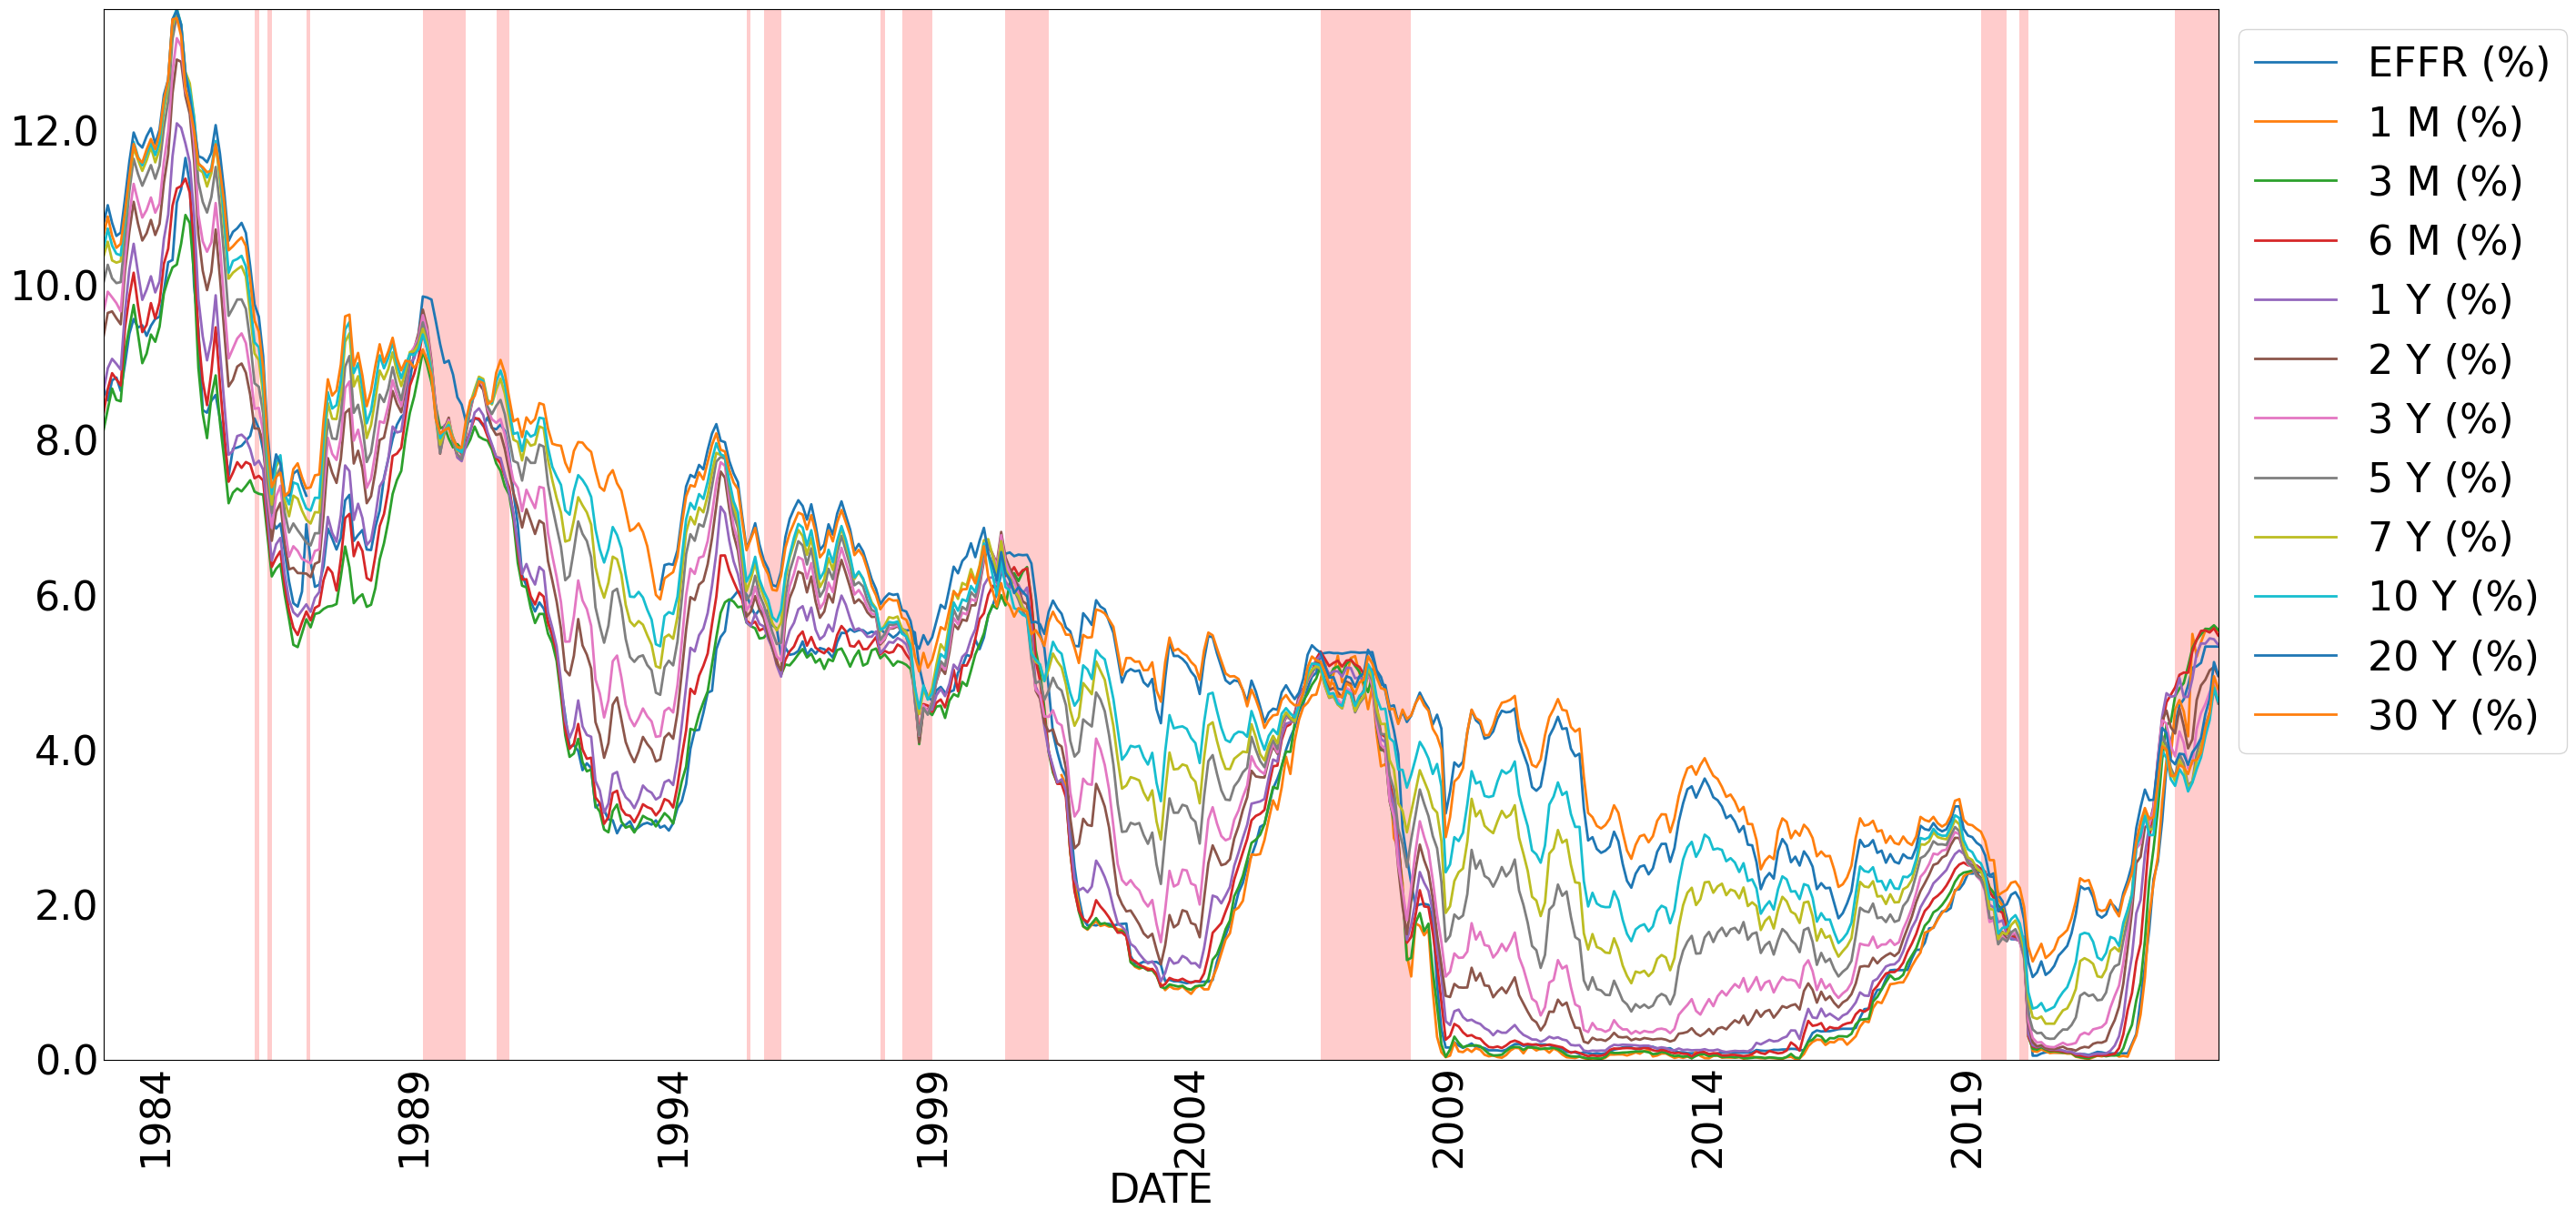

In [7]:
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.ymargin'] = 0
rate_keys = ["EFFR (%)",
             "1 M (%)",
             "3 M (%)",
             "6 M (%)",               
             "1 Y (%)",
             "2 Y (%)",
             "3 Y (%)",
             "5 Y (%)",
             "7 Y (%)",
             "10 Y (%)",
             "20 Y (%)",
             "30 Y (%)"]

plot_lines(df = data[rate_keys], 
           linewidth = 2, 
           figsize = (30, 15), 
           pp = None, 
           show_inversion = True)

C:\Users\JLCat\AppData\Local\Temp\ipykernel_12180\2498225087.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
C:\Users\JLCat\AppData\Local\Temp\ipykernel_12180\2498225087.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


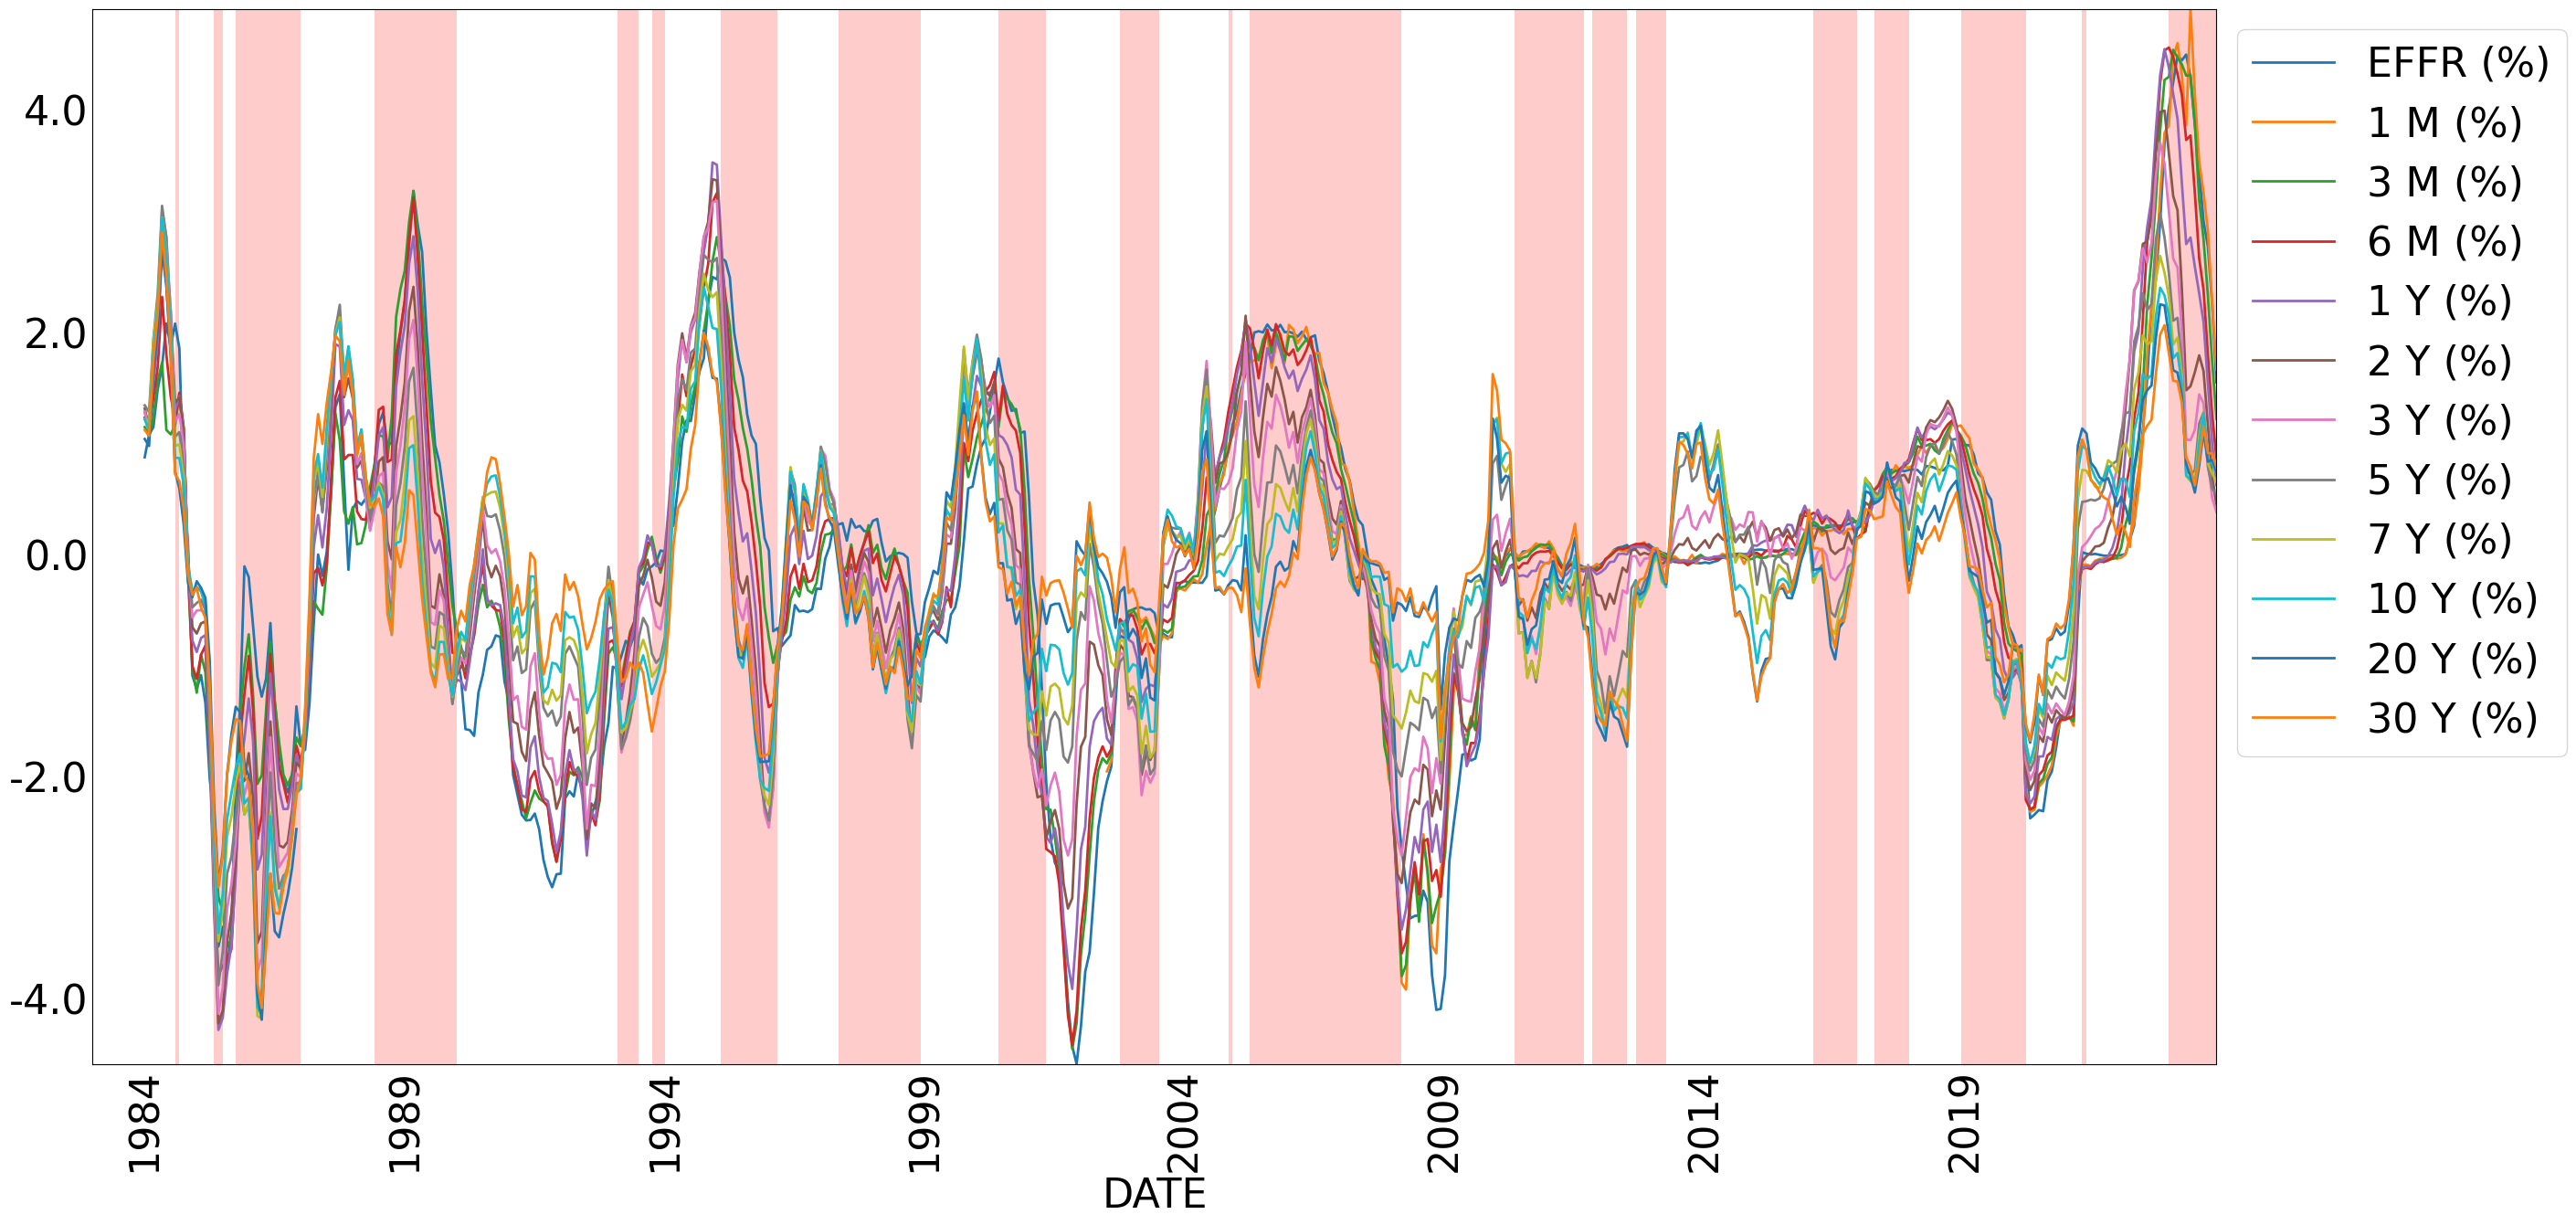

In [8]:
plot_lines(df = data[rate_keys].diff(12), 
           linewidth = 2, 
           figsize = (30, 15), 
           pp = None, 
           show_inversion = True)

C:\Users\JLCat\AppData\Local\Temp\ipykernel_12180\3920784156.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(y) + "%" for y in ax.get_yticks()])


(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0.0, 0, 'EFFR (%)'),
  Text(2.0, 0, '3 M (%)'),
  Text(4.0, 0, '1 Y (%)'),
  Text(6.0, 0, '3 Y (%)'),
  Text(8.0, 0, '7 Y (%)'),
  Text(10.0, 0, '20 Y (%)'),
  Text(12.0, 0, '')])

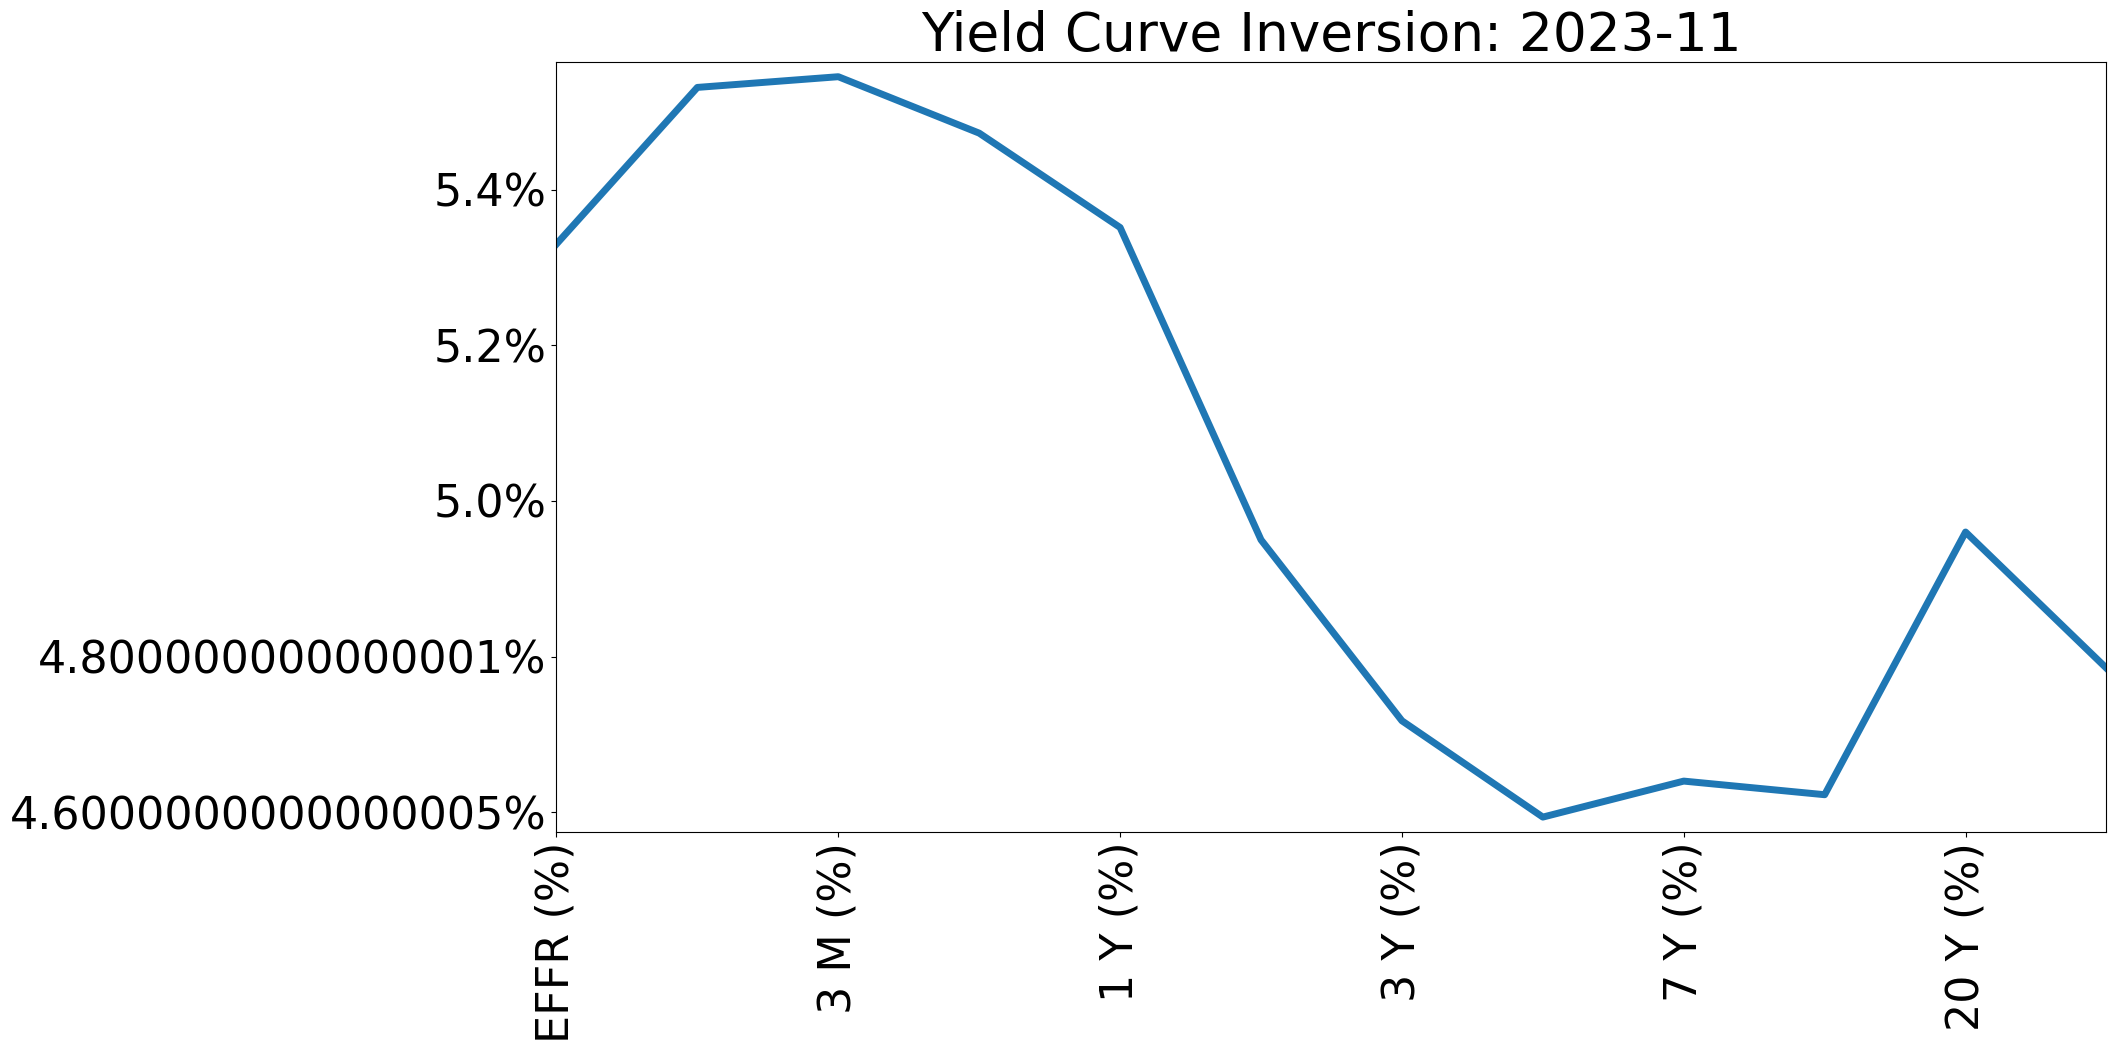

In [9]:
plt.rcParams['axes.ymargin'] = 0.02
plt.rcParams['axes.xmargin'] = 0.00
fig, ax = plt.subplots(figsize = (20,10))
data.iloc[-1][rate_keys].plot(linewidth = 5,
                              ax = ax)
ax.set_yticklabels([str(y) + "%" for y in ax.get_yticks()])
ax.set_title("Yield Curve Inversion: " + str(data.index[-1])[:7])
plt.xticks(rotation = 90)

In [10]:
plot_lines(df = data[["Expected Inflation (%)","Inflation (%)"]].dropna(), title = None, h_line = 2,
           legend = True, linewidth = 1.5, figsize = (40, 20), pp = None)

KeyError: "None of [Index(['Expected Inflation (%)', 'Inflation (%)'], dtype='object')] are in the [columns]"

In [11]:
plot_lines(df = data[["1 M (%)", "30 Y (%)", "30 Y - 1 M"]], title = "Yields", linewidth = 1.5, figsize = (40, 20), pp = None)

KeyError: "['30 Y - 1 M'] not in index"

TypeError: no numeric data to plot

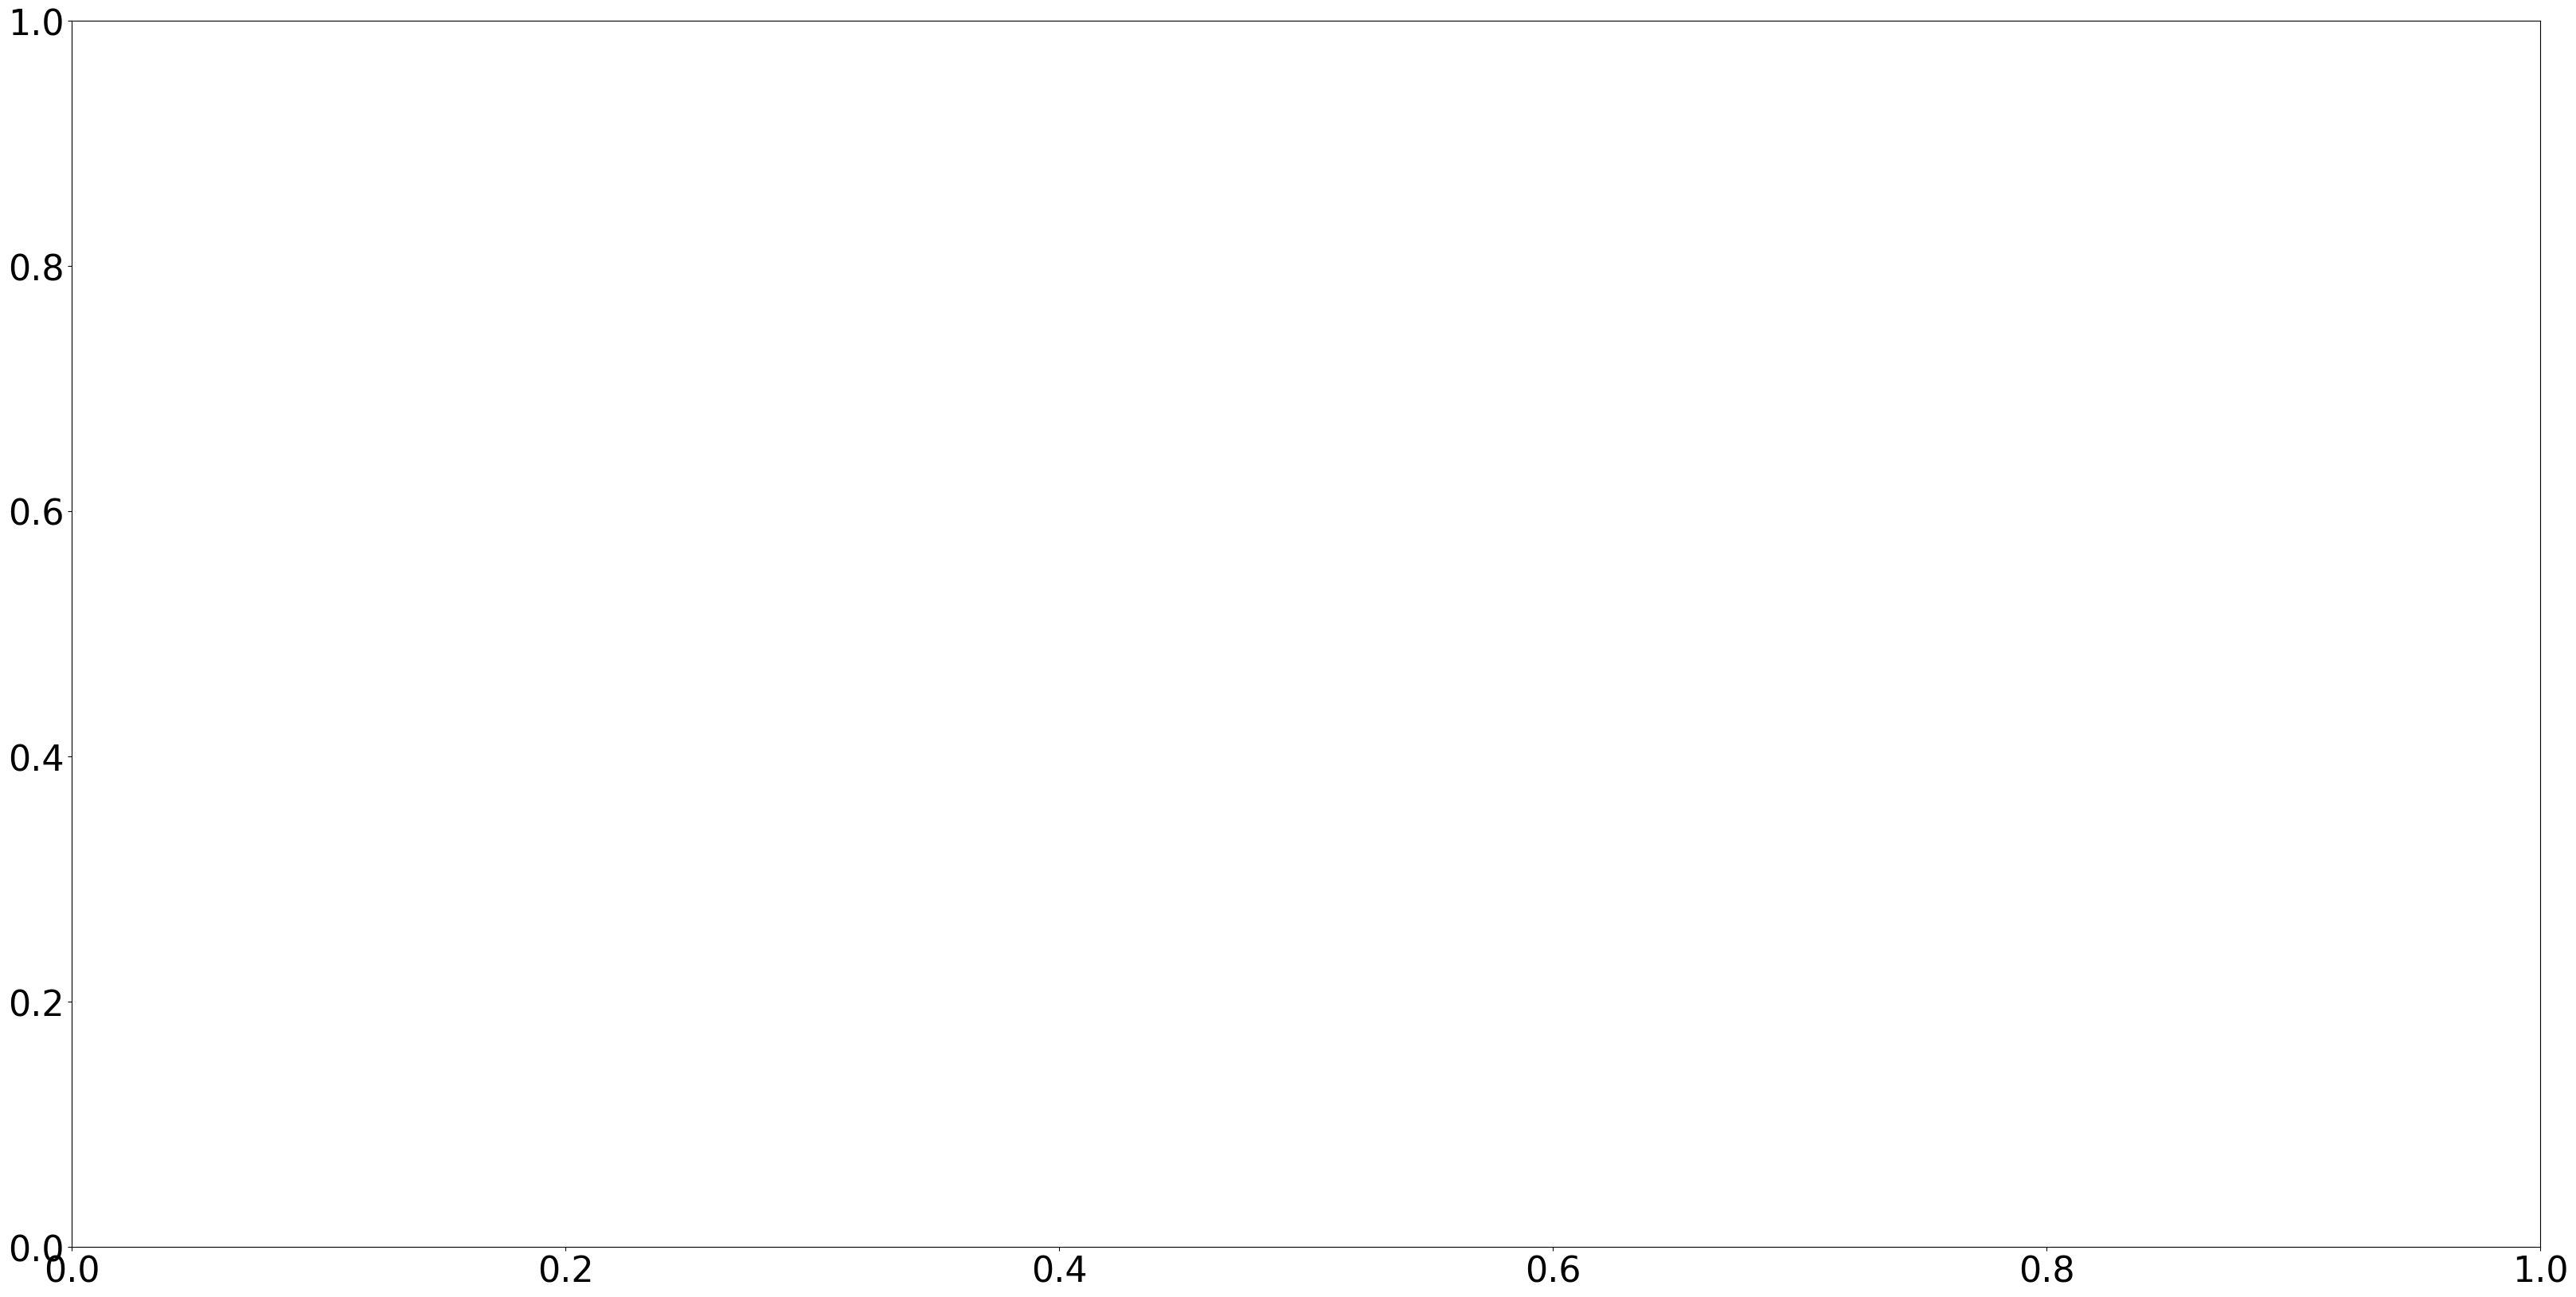

In [12]:
T_data = data.T
T_data.rename(columns={name : str(name)[:10] for name in T_data.keys()}, inplace = True)
keys = list(T_data.keys())
T_data_trunc = T_data[keys[-181::60]]
max_y = T_data.max().max()
#for key, val in T_data_trunc.items():
plot_lines(df = T_data_trunc, title = "Yield Curve", linewidth = 1.5, figsize = (40, 20), full_index = True, pp = None)

In [ ]:
from matplotlib.animation import FuncAnimation
import math         
def plot_curves(date, *kwargs):
    #ax.clear()
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])
 
    # the FuncAnimation cycles from 0 to i frames,
    plot_df = df[date]
    alpha = 1 if date in write_dates else .1
    color = "C" + str(math.ceil(int(date[5:7])/3)) if date != write_dates[0] else "k"

    # If no secondary_y (axis), plot all variables at once

    plot_df.plot.line(linewidth = linewidth, ax = ax, alpha = alpha, color = color)
    if date in write_dates: 
        plt.text(len(plot_df.keys()) - 1, plot_df["30 Y (%)"], date[5:], color = color)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(str(date)[:10] + "\n" + "Yield Curve (U.S. Treasuries)", fontsize = 30)
    print(date)
    
def init(*kwargs):
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    plt.xticks([i for i in range(len(data.index))], list(data.index))
    ax.tick_params(axis='x', rotation=90)
    # transform y-axis values from sci notation to integers
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])

dates = list(T_data.keys())[-166:]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0).drop("Expected Inflation (T10YIE)", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2020CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()

In [ ]:
dates = list(T_data.keys())[:200]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0).drop("Expected Inflation (T10YIE)", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2008CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()